<a href="https://colab.research.google.com/github/ermilovim/neuralnets/blob/master/lesson4_processing_of_source_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Первичная обработка исходных данных. Основные недостатки исходных данных: «мусор», пропуски, выбросы, –  и пути их устранения

Прежде чем передать набор данных ML-модели, его нужно очистить: обработать пропуски, дубликаты, выбросы. Как это сделать, не потеряв важную информацию?

Ни одна модель машинного обучения не выдаст осмысленных результатов, если вы предоставите ей сырые данные. После формирования выборки данных их необходимо очистить.

[Очистка данных](https://ru.wikipedia.org/wiki/%D0%9E%D1%87%D0%B8%D1%81%D1%82%D0%BA%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85) – это процесс обнаружения и исправления (или удаления) поврежденных или неточных записей из набора записей, таблицы или базы данных. Процесс включает в себя выявление неполных, неправильных, неточных или несущественных данных, а затем замену, изменение или удаление «загрязненных» данных.

Определение очень длинное и не очень понятное :(

Чтобы детально во всем разобраться, разобьем это определение на составные части и создадим пошаговый гайд по очистке данных на Python. Здесь мы разберем методы поиска и исправления:



*   отсутствующих данных;
*   нетипичных данных – выбросов;
*   неинформативных данных – дубликатов;
*   несогласованных данных – одних и тех же данных, представленных в разных регистрах или форматах;

Базой для наших экспериментов послужит [набор данных по ценам на жилье в России](https://www.kaggle.com/c/sberbank-russian-housing-market/overview/description), найденный на Kaggle. Мы не станем очищать всю базу целиком, но разберем на ее основе главные методы и операции.


Прежде чем переходить к процессу очистки, всегда нужно представлять исходный датасет. Давайте быстро взглянем на сами данные:




In [ ]:
# импорт пакетов
import pandas as pd
import numpy as np
import seaborn as sns
# seaborn - также библиотека для визуализации данных, подробнее о ней на следуюзем уроке.
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None


#https://bit.ly/3jqdogp

In [ ]:
# чтение данных
# df = pd.read_csv('/content/sample_data/test.csv')
df = pd.read_csv('/content/drive/MyDrive/train.csv')
# https://bit.ly/3jqdogp


# shape and data types of the data
print(df.shape)
print(df.dtypes)

In [ ]:
df.head()

.shape показывает, сколько в датафрейме строк и колонок. Он возвращает пару значений (n_rows, n_columns). Сначала идут строки, потом колонки.

С помощью .dtypes узнаем типы данных, находящихся в каждой колонке и поймем, надо ли их обрабатывать.

In [ ]:
df.head()

In [ ]:
# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print("Numeric columns:\n", numeric_cols)

# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print("Non numeric columns:\n", non_numeric_cols)

Этот код покажет нам, что набор данных состоит из 30471 строки и 292 столбцов. Мы увидим, являются ли эти столбцы числовыми или категориальными признаками.

Теперь мы можем пробежаться по чек-листу «грязных» типов данных и очистить их один за другим.

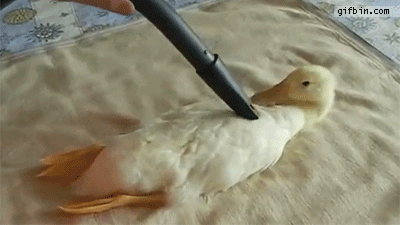

## 1. Отсутствующие данные

###1.1. Как обнаружить?

Рассмотрим три метода обнаружения отсутствующих данных в наборе.

####1.1.1. Тепловая карта пропущенных значений

Когда признаков в наборе не очень много, визуализируйте пропущенные значения с помощью тепловой карты.

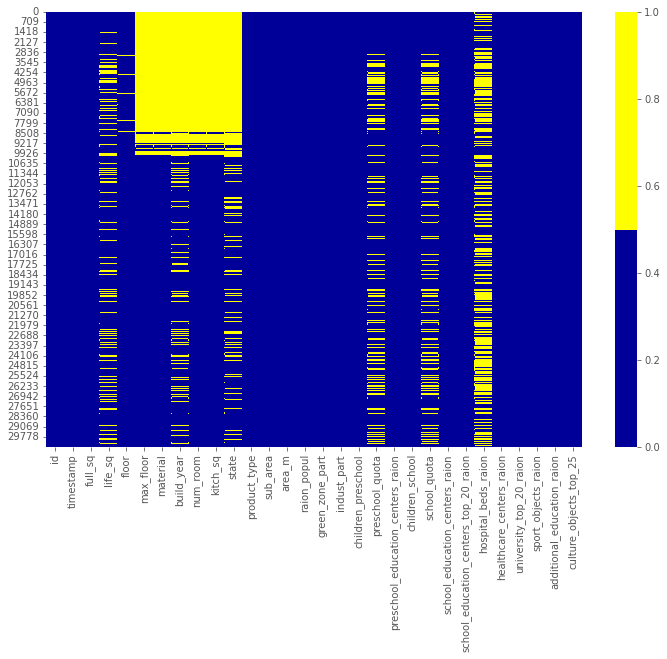

In [ ]:
cols = df.columns[0:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Приведенная карта демонстрирует паттерн пропущенных значений для первых 30 признаков набора. По горизонтальной оси расположены признаки, по вертикальной – количество записей/строк. Желтый цвет соответствует пропускам данных.

Заметно, например, что признак life_sq имеет довольно много пустых строк, а признак floor – напротив, около 7000 строки.

####1.1.2. Процентный список пропущенных данных

Если в наборе много признаков и визуализация занимает много времени, можно составить процентное соотношение отсутствующих записей для каждого признака.



In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if round(pct_missing*100) > 40:
      print('{} - {}%'.format(col, round(pct_missing*100)))

build_year - 45%
state - 44%
hospital_beds_raion - 47%
cafe_sum_500_min_price_avg - 44%
cafe_sum_500_max_price_avg - 44%
cafe_avg_price_500 - 44%


Этот список является полезным дополнением к визуализации тепловой карты.

####1.1.3. Гистограмма пропущенных данных

Еще одна хорошая техника визуализации для наборов с большим количеством признаков – построение гистограммы для числа отсутствующих значений в записи.


created missing indicator for: life_sq
created missing indicator for: floor
created missing indicator for: max_floor
created missing indicator for: material
created missing indicator for: build_year
created missing indicator for: num_room
created missing indicator for: kitch_sq
created missing indicator for: state
created missing indicator for: preschool_quota
created missing indicator for: school_quota
created missing indicator for: hospital_beds_raion
created missing indicator for: raion_build_count_with_material_info
created missing indicator for: build_count_block
created missing indicator for: build_count_wood
created missing indicator for: build_count_frame
created missing indicator for: build_count_brick
created missing indicator for: build_count_monolith
created missing indicator for: build_count_panel
created missing indicator for: build_count_foam
created missing indicator for: build_count_slag
created missing indicator for: build_count_mix
created missing indicator for: raio

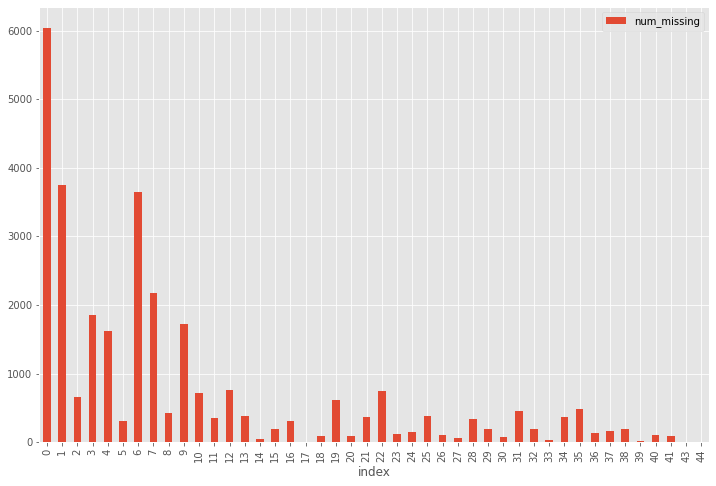

In [ ]:
# сначала создаем индикатор для признаков с пропущенными данными
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

Отсюда понятно, что из 30 тыс. записей более 6 тыс. строк не имеют ни одного пропущенного значения, а еще около 4 тыс.– всего одно. Такие строки можно использовать в качестве «эталонных» для проверки различных гипотез по дополнению данных.

###1.2. Что делать с пропущенными значениями?

Не существует общих решений для проблемы отсутствующих данных. Для каждого конкретного набора приходится искать наиболее подходящие методы или их комбинации.

Разберем четыре самых распространенных техники. Они помогут в простых ситуациях, но, скорее всего, придется проявить творческий подход и поискать нетривиальные решения.

####1.2.1. Отбрасывание записей

Первая техника в статистике называется методом удаления по списку и заключается в простом отбрасывании записи, содержащей пропущенные значения. Это решение подходит только в том случае, если недостающие данные не являются информативными.

Для отбрасывания можно использовать и другие критерии. Например, из гистограммы, построенной в предыдущем разделе, мы узнали, что лишь небольшое количество строк содержат более 35 пропусков. Мы можем создать новый набор данных *df_less_missing_rows*, в котором отбросим эти строки.

In [ ]:
# отбрасываем строки с большим количеством пропусков
ind_missing = df[df['num_missing'] > 35].index
df_less_missing_rows = df.drop(ind_missing, axis=0)

In [ ]:
print(df.shape)
print(df_less_missing_rows.shape)

(30471, 344)
(29779, 344)


####1.2.2. Отбрасывание признаков

Как и предыдущая техника, отбрасывание признаков может применяться только для неинформативных признаков.

В процентном списке, построенном ранее, мы увидели, что признак *hospital_beds_raion* имеет высокий процент недостающих значений – 47%. Мы можем полностью отказаться от этого признака:

In [ ]:
cols_to_drop = ['hospital_beds_raion']
df_less_hos_beds_raion = df.drop(cols_to_drop, axis=1)

####1.2.3. Внесение недостающих значений

Для численных признаков можно воспользоваться методом принудительного заполнения пропусков. Например, на место пропуска можно записать среднее или медианное значение, полученное из остальных записей.

Для категориальных признаков можно использовать в качестве заполнителя наиболее часто встречающееся значение.

Возьмем для примера признак *life_sq* и заменим все недостающие значения медианой этого признака:

In [ ]:
med = df['life_sq'].median()
print(med)
df['life_sq'] = df['life_sq'].fillna(med)

30.0


Одну и ту же стратегию принудительного заполнения можно применить сразу для всех числовых признаков:

In [ ]:
# impute the missing values and create the missing value indicator variables for each numeric column.
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        med = df[col].median()
        df[col] = df[col].fillna(med)

К счастью, в нашем наборе не нашлось пропусков в категориальных признаках. Но это не мешает нам продемонстрировать использование той же стратегии:

In [ ]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        
        top = df[col].describe()['top'] # impute with the most frequent value.
        df[col] = df[col].fillna(top)

####1.2.4. Замена недостающих значений

Можно использовать некоторый дефолтный плейсхолдер для пропусков, например, новую категорию _MISSING_ для категориальных признаков или число -999 для числовых.

Таким образом, мы сохраняем данные о пропущенных значениях, что тоже может быть ценной информацией.

In [ ]:
# категориальные признаки
df['sub_area'] = df['sub_area'].fillna('_MISSING_')

# численные признаки
df['life_sq'] = df['life_sq'].fillna(-999)

##2. Нетипичные данные (выбросы)

Выбросы – это данные, которые существенно отличаются от других наблюдений. Они могут соответствовать реальным отклонениям, но могут быть и просто ошибками.

###2.1. Как обнаружить выбросы?

Для численных и категориальных признаков используются разные методы изучения распределения, позволяющие обнаружить выбросы.

####2.1.1. Гистограмма/коробчатая диаграмма
Если признак численный, можно построить гистограмму или коробчатую диаграмму. Посмотрим на примере уже знакомого нам признака *life_sq*.

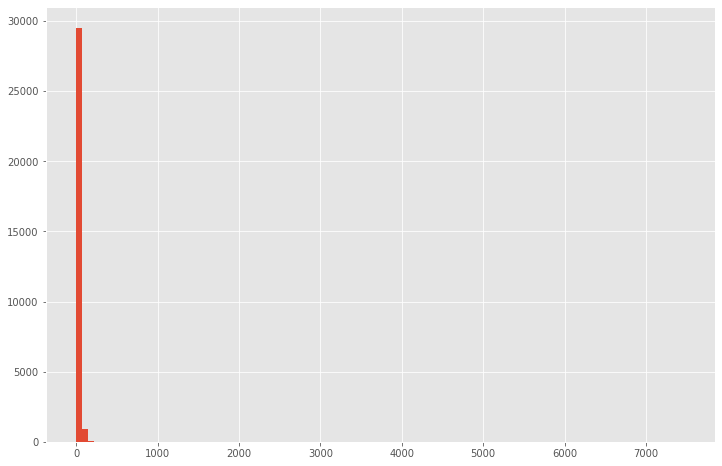

In [ ]:
df['life_sq'].hist(bins=100)


Из-за возможных выбросов данные выглядят сильно искаженными.

Чтобы изучить особенность поближе, построим коробчатую диаграмму.



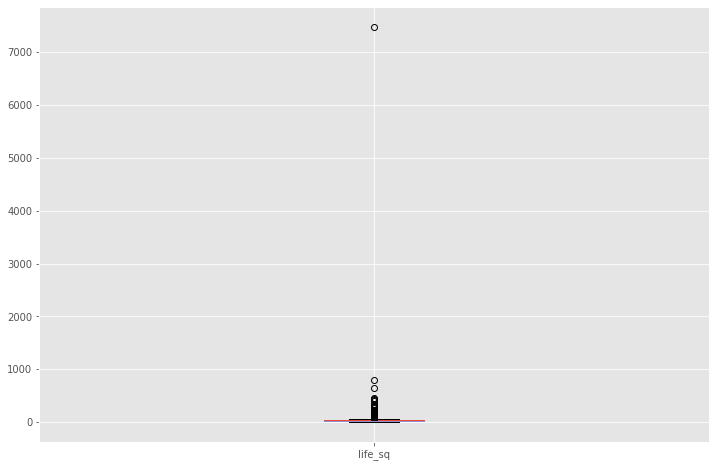

In [ ]:
df.boxplot(column=['life_sq'])


Видим, что есть выброс со значением более 7000.

####2.1.2. Описательная статистика

Отклонения числовых признаков могут быть слишком четкими, чтобы не визуализироваться коробчатой диаграммой. Вместо этого можно проанализировать их описательную статистику.

Например, для признака *life_sq* видно, что максимальное значение равно 7478, в то время как 75% равен только 43. Значение 7478 – выброс.



In [ ]:
df['life_sq'].describe()


count    30471.000000
mean        33.480883
std         46.522251
min          0.000000
25%         22.000000
50%         30.000000
75%         38.000000
max       7478.000000
Name: life_sq, dtype: float64

####2.1.3. Столбчатая диаграмма
Для категориальных признаков можно построить столбчатую диаграмму – для визуализации данных о категориях и их распределении.

Например, распределение признака ecology вполне равномерно и допустимо. Но если существует категория только с одним значением "другое", то это будет выброс.

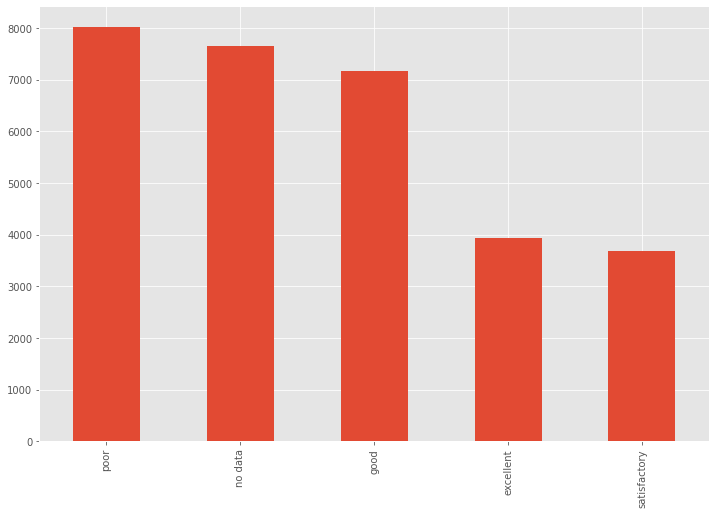

In [ ]:
df['ecology'].value_counts().plot.bar()


####2.1.4. Другие методы

Для обнаружения выбросов можно использовать другие методы, например, построение точечной диаграммы, z-оценку или кластеризацию. На данном занятии они не рассматриваются.

###2.2. Что делать?

Выбросы довольно просто обнаружить, но выбор способа их устранения слишком существенно зависит от специфики набора данных и целей проекта. Их обработка во многом похожа на обработку пропущенных данных, которую мы разбирали в предыдущем разделе. Можно удалить записи или признаки с выбросами, либо скорректировать их, либо оставить без изменений.

Переходим к более простой части очистки данных – удалению мусора.

Вся информация, поступающая в модель, должна служить целям проекта. Если она не добавляет никакой ценности, от нее следует избавиться.

Три основных типа «ненужных» данных:

* неинформативные признаки с большим количеством одинаковых значений,
* нерелевантные признаки,
* дубликаты записей.
Рассмотрим работу с каждым типом отдельно.



##3. Неинформативные признаки

Если признак имеет слишком много строк с одинаковыми значениями, он не несет полезной информации для проекта.

###3.1. Как обнаружить?

Составим список признаков, у которых более 95% строк содержат одно и то же значение.

In [ ]:
num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)

Теперь можно последовательно перебрать их и определить, несут ли они полезную информацию.

###3.2. Что делать?

Если после анализа причин получения повторяющихся значений вы пришли к выводу, что признак не несет полезной информации, используйте drop().

##4. Нерелевантные признаки
Нерелевантные признаки обнаруживаются ручным отбором и оценкой значимости. Например, признак, регистрирующий температуру воздуха в Торонто точно не имеет никакого отношения к прогнозированию цен на российское жилье. Если признак не имеет значения для проекта, его нужно исключить.

##5. Дубликаты записей
Если значения признаков (всех или большинства) в двух разных записях совпадают, эти записи называются дубликатами.

In [ ]:
# отбрасываем неуникальные строки
df_dedupped = df.drop('id', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(df.shape)
print(df_dedupped.shape)

(30471, 344)
(30461, 343)


In [ ]:
df_dedupped.head()

Другой распространенный способ вычисления дубликатов: по набору ключевых признаков. Например, неуникальными можно считать записи с одной и той же площадью жилья, ценой и годом постройки.

Найдем в нашем наборе дубликаты по группе критических признаков – *full_sq,life_sq, floor, build_year, num_room, price_doc*:

In [ ]:
key = ['timestamp', 'full_sq', 'life_sq', 'floor', 'build_year', 'num_room', 'price_doc']

df.fillna(-999).groupby(key)['id'].count().sort_values(ascending=False).head(20)

###5.2. Что делать с дубликатами?

Очевидно, что повторяющиеся записи нам не нужны, значит, их нужно исключить из набора.

Вот так выглядит удаление дубликатов, основанное на наборе ключевых признаков:

In [ ]:
df_dedupped2 = df.drop_duplicates(subset=key)

print(df.shape)
print(df_dedupped2.shape)

В результате новый набор df_dedupped2 стал короче на 16 записей.

Большая проблема очистки данных – разные форматы записей. Для корректной работы модели важно, чтобы набор данных соответствовал определенным стандартам – необходимо тщательное исследование с учетом специфики самих данных. Мы рассмотрим четыре самых распространенных несогласованности:

* Разные регистры символов.
* Разные форматы данных (например, даты).
* Опечатки в значениях категориальных признаков.
* Адреса.

##6. Разные регистры символов

Непоследовательное использование разных регистров в категориальных значениях является очень распространенной ошибкой, которая может существенно повлиять на анализ данных.

###6.1. Как обнаружить?

Давайте посмотрим на признак sub_area:

In [ ]:
df['sub_area'].value_counts(dropna=False)

Poselenie Sosenskoe               1776
Nekrasovka                        1611
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
                                  ... 
Molzhaninovskoe                      3
Poselenie Shhapovskoe                2
Poselenie Kievskij                   2
Poselenie Klenovskoe                 1
Poselenie Mihajlovo-Jarcevskoe       1
Name: sub_area, Length: 146, dtype: int64

В нем содержатся названия населенных пунктов. Все выглядит вполне стандартизированным.

Но если в какой-то записи вместо Poselenie Sosenskoe окажется poselenie sosenskoe, они будут расценены как два разных значения.

###6.2. Что делать?

Эта проблема легко решается принудительным изменением регистра:

In [ ]:
# пусть все будет в нижнем регистре
df['sub_area_lower'] = df['sub_area'].str.lower()
df['sub_area_lower'].value_counts(dropna=False)

poselenie sosenskoe               1776
nekrasovka                        1611
poselenie vnukovskoe              1372
poselenie moskovskij               925
poselenie voskresenskoe            713
                                  ... 
molzhaninovskoe                      3
poselenie shhapovskoe                2
poselenie kievskij                   2
poselenie klenovskoe                 1
poselenie mihajlovo-jarcevskoe       1
Name: sub_area_lower, Length: 146, dtype: int64

##7. Разные форматы данных

Ряд данных в наборе находится не в том формате, с которым нам было бы удобно работать. Например, даты, записанные в виде строки, следует преобразовать в формат *DateTime*.


###7.1. Как обнаружить?

Признак *timestamp* представляет собой строку, хотя является датой:

In [ ]:
df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_avg_price_2000_ismissing,cafe_sum_3000_min_price_avg_ismissing,cafe_sum_3000_max_price_avg_ismissing,cafe_avg_price_3000_ismissing,prom_part_5000_ismissing,cafe_sum_5000_min_price_avg_ismissing,cafe_sum_5000_max_price_avg_ismissing,cafe_avg_price_5000_ismissing,num_missing,sub_area_lower
0,1,2011-08-20,43,27.0,4.0,12.0,1.0,1979.0,2.0,6.0,...,False,False,False,False,False,False,False,False,9,bibirevo
1,2,2011-08-23,34,19.0,3.0,12.0,1.0,1979.0,2.0,6.0,...,False,False,False,False,False,False,False,False,6,nagatinskij zaton
2,3,2011-08-27,43,29.0,2.0,12.0,1.0,1979.0,2.0,6.0,...,False,False,False,False,False,False,False,False,6,tekstil'shhiki
3,4,2011-09-01,89,50.0,9.0,12.0,1.0,1979.0,2.0,6.0,...,False,False,False,False,False,False,False,False,7,mitino
4,5,2011-09-05,77,77.0,4.0,12.0,1.0,1979.0,2.0,6.0,...,False,False,False,False,False,False,False,False,6,basmannoe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,2015-06-30,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,...,False,False,False,False,False,False,False,False,1,otradnoe
30467,30470,2015-06-30,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,...,False,False,False,False,False,False,False,False,0,tverskoe
30468,30471,2015-06-30,45,30.0,10.0,20.0,1.0,1979.0,1.0,1.0,...,False,False,False,False,False,False,False,False,21,poselenie vnukovskoe
30469,30472,2015-06-30,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,...,False,False,False,False,False,False,False,False,0,obruchevskoe


###7.2. Что же делать?

Чтобы было проще анализировать транзакции по годам и месяцам, значения признака *timestamp* следует преобразовать в удобный формат:

In [ ]:
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
df['year'] = df['timestamp_dt'].dt.year
df['month'] = df['timestamp_dt'].dt.month
df['weekday'] = df['timestamp_dt'].dt.weekday

print(df['year'].value_counts(dropna=False))
print()
print(df['month'].value_counts(dropna=False))

2014    13662
2013     7978
2012     4839
2015     3239
2011      753
Name: year, dtype: int64

12    3400
4     3191
3     2972
11    2970
10    2736
6     2570
5     2496
9     2346
2     2275
7     1875
8     1831
1     1809
Name: month, dtype: int64


##8. Опечатки

Опечатки в значениях категориальных признаков приводят к таким же проблемам, как и разные регистры символов.

###8.1. Как обнаружить?
Для обнаружения опечаток требуется особый подход. В нашем наборе данных о недвижимости опечаток нет, поэтому для примера создадим новый набор. В нем будет признак city, а его значениями будут torontoo и tronto. В обоих случаях это опечатки, а правильное значение – toronto.

Простой способ идентификации подобных элементов – нечеткая логика или редактирование расстояния. Суть этого метода заключается в измерении количества букв (расстояния), которые нам нужно изменить, чтобы из одного слова получить другое.

Предположим, нам известно, что в признаке city должно находиться одно из четырех значений: toronto, vancouver, montreal или calgary. Мы вычисляем расстояние между всеми значениями и словом toronto (и vancouver).

Те слова, в которых содержатся опечатки, имеют меньшее расстояние с правильным словом, так как отличаются всего на пару букв.

In [ ]:
from nltk.metrics import edit_distance

df_city_ex = pd.DataFrame(data={'city': ['torontoo', 'toronto', 'tronto', 'vancouver', 'vancover', 'vancouvr', 'montreal', 'calgary']})


df_city_ex['city_distance_toronto'] = df_city_ex['city'].map(lambda x: edit_distance(x, 'toronto'))
df_city_ex['city_distance_vancouver'] = df_city_ex['city'].map(lambda x: edit_distance(x, 'vancouver'))
df_city_ex

,city,city_distance_toronto,city_distance_vancouver
0,torontoo,1,8
1,toronto,0,8
2,tronto,1,8
3,vancouver,8,0
4,vancover,7,1
5,vancouvr,7,1
6,montreal,7,8
7,calgary,7,8


###8.2. Что делать?

Мы можем установить критерии для преобразования этих опечаток в правильные значения.

Например, если расстояние некоторого значения от слова toronto не превышает 2 буквы, мы преобразуем это значение в правильное – toronto.

In [ ]:
msk = df_city_ex['city_distance_toronto'] <= 2
df_city_ex.loc[msk, 'city'] = 'toronto'

msk = df_city_ex['city_distance_vancouver'] <= 2
df_city_ex.loc[msk, 'city'] = 'vancouver'

df_city_ex

##9. Адреса

Адреса – ужасная головная боль для всех аналитиков данных. Ведь мало кто следует стандартному формату, вводя свой адрес в базу данных.

###9.1. Как обнаружить?
Проще предположить, что проблема разных форматов адреса точно существует. Даже если визуально вы не обнаружили беспорядка в этом признаке, все равно стоит стандартизировать их для надежности.

В нашем наборе данных по соображениям конфиденциальности отсутствует признак адреса, поэтому создадим новый набор df_add_ex:

In [ ]:
df_add_ex = pd.DataFrame(['123 MAIN St Apartment 15', '123 Main Street Apt 12   ', '543 FirSt Av', '  876 FIRst Ave.'], columns=['address'])
df_add_ex

,address
0,123 MAIN St Apartment 15
1,123 Main Street Apt 12
2,543 FirSt Av
3,876 FIRst Ave.


###9.2. Что делать?

Минимальное форматирование включает следующие операции:

* приведение всех символов к нижнему регистру;
* удаление пробелов в начале и конце строки;
* удаление точек;
* стандартизация формулировок: замена street на st, apartment на apt и т. д.

In [ ]:
df_add_ex['address_std'] = df_add_ex['address'].str.lower()
df_add_ex['address_std'] = df_add_ex['address_std'].str.strip()
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\.', '') 
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bstreet\\b', 'st') 
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bapartment\\b', 'apt') 
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bav\\b', 'ave') 

df_add_ex

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,address,address_std
0,123 MAIN St Apartment 15,123 main st apt 15
1,123 Main Street Apt 12,123 main st apt 12
2,543 FirSt Av,543 first ave
3,876 FIRst Ave.,876 first ave
